In [2]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
from scipy import stats as scipy_stats
import scipy.signal
import rasterio
import rasterio.features
from rasterio import MemoryFile
from affine import Affine
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import Polygon, MultiPolygon, shape

# Import libs
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)
from s3utils import *

In [17]:
S3R = S3Helper('roof-index')
slope_path = "missoula/geospatial/downtown_slope.tif" 
slope = S3R.read_tif_from_s3_as_rio(slope_path) 
slope_arr = slope.read(1)
affine = slope.transform

bldgs_path = "missoula/geospatial/downtown_flat_beta.zip"
bldgs = S3R.read_shp_from_s3_as_gpd(bldgs_path).to_crs(6514)
bldgs = bldgs[bldgs['flat'] == 1]

## Make a new GDF that is a ring around the outer meter of the building (theoretically where the parapet would be)

<AxesSubplot:>

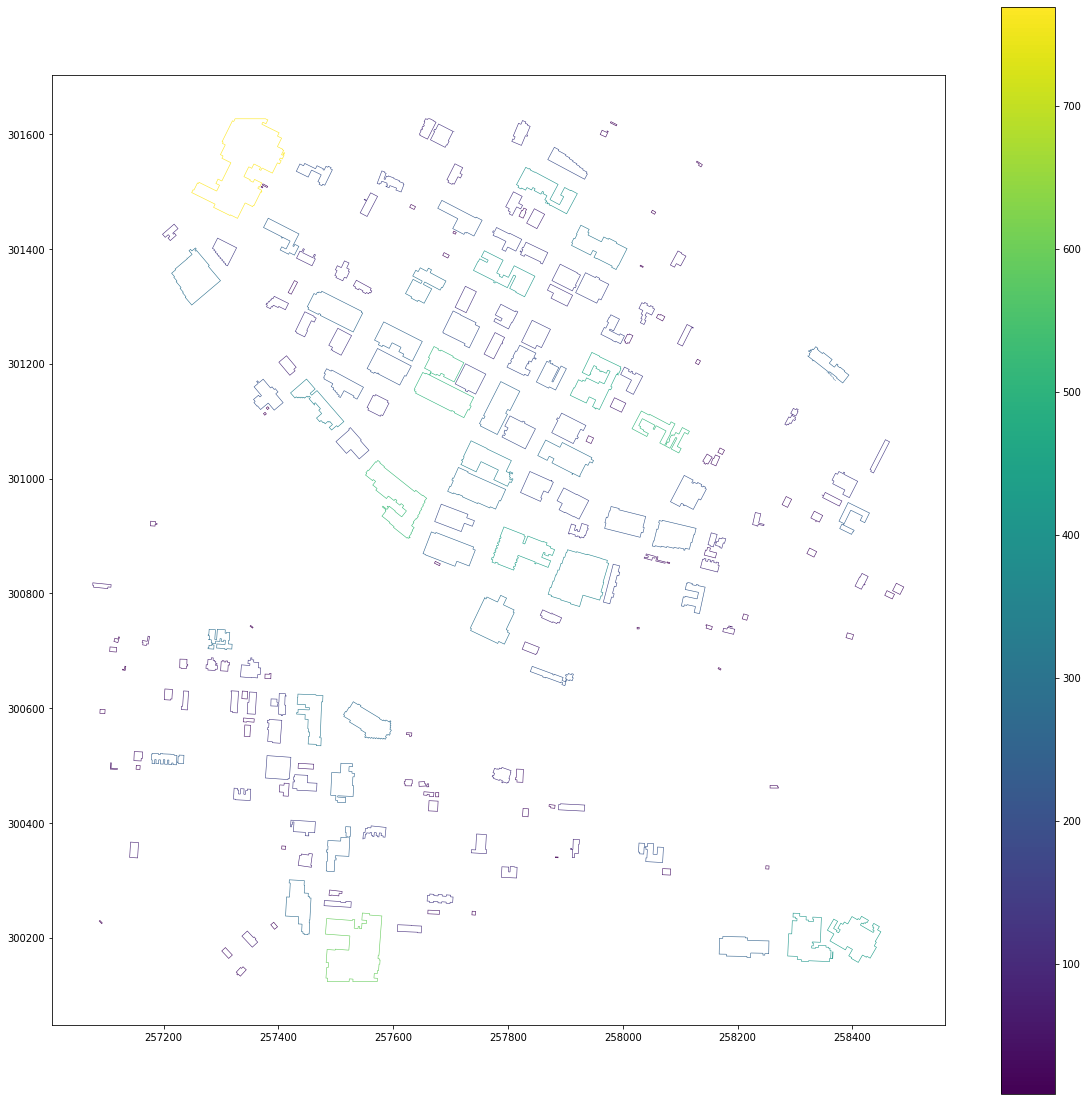

In [18]:
bldgs['area'] = bldgs['geometry'].area

bounds = bldgs['geometry']
bounds = gpd.GeoDataFrame({'geometry': bounds, 'fid': bldgs['fid']})

buff = bldgs['geometry'].buffer(-1)
buff = gpd.GeoDataFrame({'geometry': buff, 'fid': bldgs['fid']})


parapet = gpd.overlay(bounds, buff, how='difference')
parapet['area'] = parapet['geometry'].area
fig, ax = plt.subplots(1,1, figsize=(20,20))
parapet.plot(column='area', ax=ax, legend=True)

## Calculate the median slope of the outer edge of the building

<AxesSubplot:>

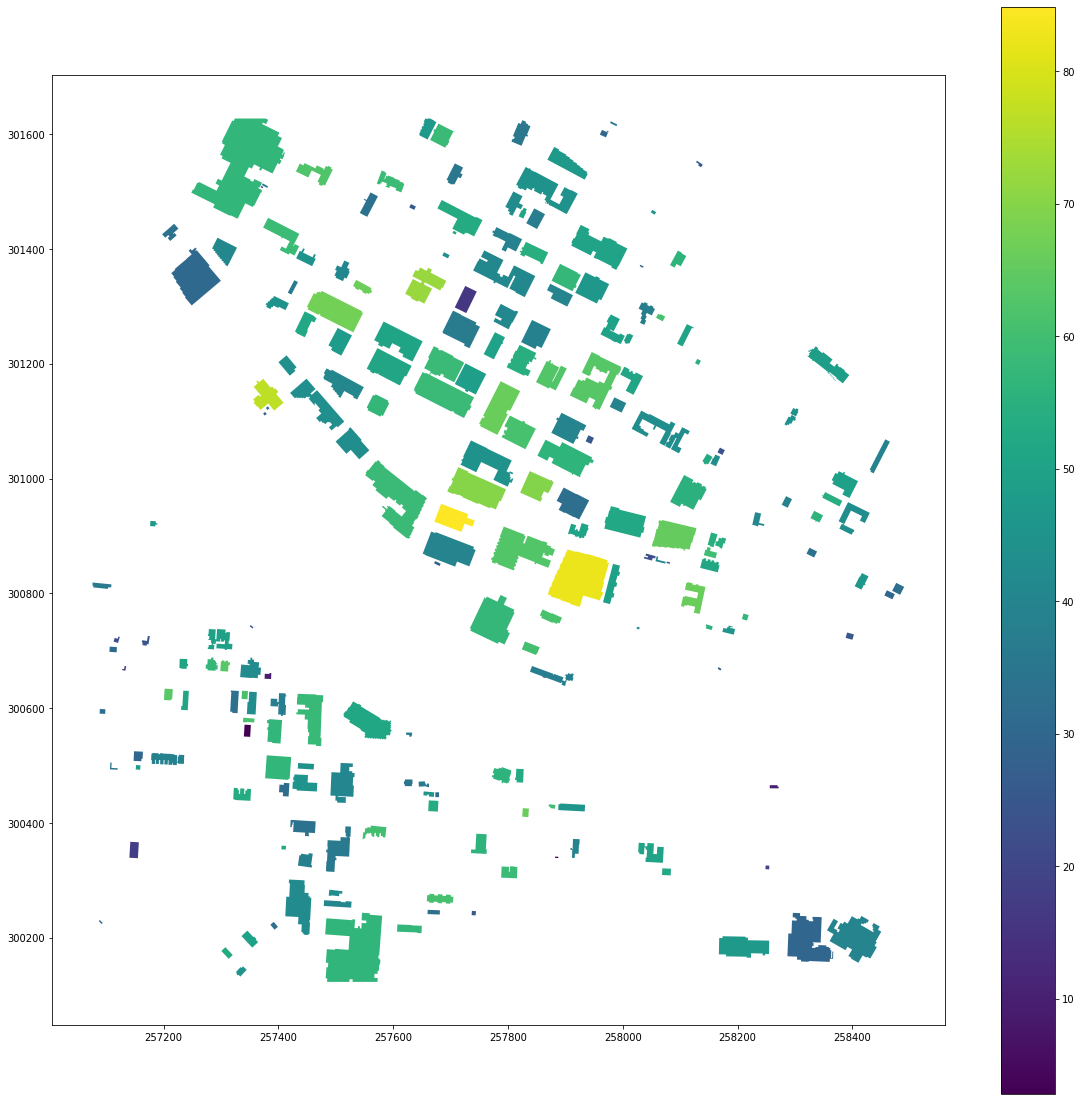

In [20]:
def add_stats(shp, ras, col_name):
    zstats = rasterstats.zonal_stats(shp, ras.read(1), affine=ras.transform,
    nodata=ras.nodata, geojson_out=True, stats="median")

    stat = []
    for b in zstats:
        temp = (b['properties']['fid'], b['properties']['median'])
        stat.append(temp)

    df = gpd.GeoDataFrame(stat, columns=['fid', col_name])
    full_data = pd.merge(shp, df)
    
    return full_data

parapet = add_stats(parapet, slope, 'parapet_slope')
bldgs['parapet_slope'] = parapet['parapet_slope'].values

fig, ax = plt.subplots(1,1, figsize=(20,20))
bldgs.plot(column='parapet_slope', legend=True, ax=ax)